<a href="https://colab.research.google.com/github/foxtrotmike/LWR/blob/master/lwr_xor2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An implementation of Generalized Learning with Rejection for Classification and Regression Problems 
### by Amina Asif, Fayyaz ul Amir Afsar Minhas (https://arxiv.org/abs/1911.00896) for a toy XOR problem.

Learning with rejection (LWR) allows development of machine learning
systems with the ability to discard low confidence decisions generated by a prediction
model. That is, just like human experts, LWR allows machine models to abstain from
generating a prediction when reliability of the prediction is expected to be low. Several
frameworks for this learning with rejection have been proposed in the literature.
However, most of them work for classification problems only and regression with
rejection has not been studied in much detail. In this work, we present a neural
framework for LWR based on a generalized meta-loss function that involves
simultaneous training of two neural network models: a predictor model for generating
predictions and a rejecter model for deciding whether the prediction should be accepted
or rejected. The proposed framework can be used for classification as well as regression
and other related machine learning tasks. 


The paper presents a simple loss function that can be used to develop LWR solution based on two neural models: a prediction network $h(x;\theta_h)$ and a rejection network and a rejection network $r(x;\theta_r)$. These networks can be trained simultaneously using the proposed joint loss function which penalizes prediction errors and reduces the number of rejections. The hyper-parameter $c$ controls the relative contribution of these factors.

$$L(x,y) = max{\{0,r(x;\theta_r)+l(h(x;\theta_h),y),c(1-r(x;\theta_r)\}}$$

AUC without rejection= 0.9454739999999998
AUC with rejection= 0.9762062302157192
Number of examples rejected= 541 / 2000


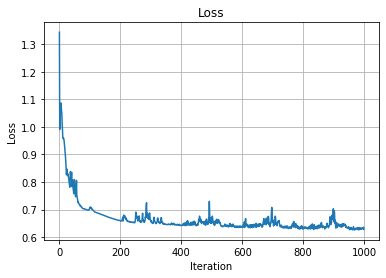

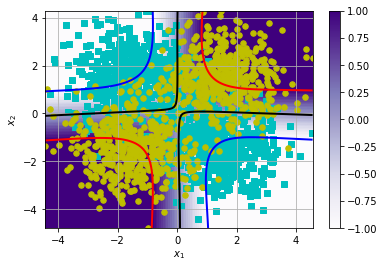

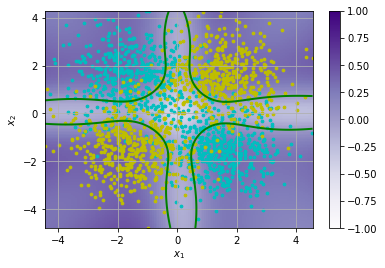

In [16]:
# -*- coding: utf-8 -*-
"""
Created on Fri Dec 13 00:50:45 2019

@author: Amina Asif
Use mish as activation (can be replaced with tanh)
Also uses cyclical learning rate (can be replaced with simple Adam) https://towardsdatascience.com/adaptive-and-cyclical-learning-rates-using-pytorch-2bf904d18dee
"""

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch
from sklearn.metrics import roc_auc_score as auc_roc
import itertools
import warnings
import math
from torch.optim.optimizer import Optimizer, required

def loss_rej(y, h, r=1, c=0):
    if type(r)!=type(1):
        r=np.array(r)
    l_total=np.mean(np.sum(((y*h)<=0)*(r>0)+c*(r<=0)))
    l_rejection=np.mean(np.sum(c*(r<=0)))
    return l_total, l_rejection

def hinge(y_true, y_pred):
    zero = torch.Tensor([0]) 
    return torch.max(zero, 1 - y_true * y_pred)

class Net(nn.Module):
    """
    Classification Network: Should have more capacity than the classification net
    """
    def __init__(self,d):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(d,10) 
        self.out = nn.Linear(10,1)
    def forward(self,x):
        x = self.hidden1(x)
        #x = torch.tanh(x) 
        x = x*(torch.tanh(F.softplus(x))) #MISH:  (https://arxiv.org/abs/1908.08681v1)
        x = self.out(x)
        return x

class RejNet(nn.Module):
    """
    Rejection Network: Should have more capacity than the classification net
    """
    def __init__(self,d):
        super(RejNet, self).__init__()
        self.hidden1 = nn.Linear(d,200)   
        self.out = nn.Linear(200,1)
    def forward(self,x):
        x = self.hidden1(x)
        #x = torch.tanh(x)      
        x = x*(torch.tanh(F.softplus(x)))
        x = self.out(x)
        x = torch.tanh(x)
        return x


###################Generate Data######################
d=1.50
n=500
X1=np.random.randn(n,2)+d*np.array([1,1])
l1=[1.0]*len(X1)
X2=np.random.randn(n,2)+d*np.array([1,-1])
l2=[-1.0]*len(X2)
X3=np.random.randn(n,2)+d*np.array([-1,1])
l3=[-1.0]*len(X3)
X4=np.random.randn(n,2)+d*np.array([-1,-1])
l4=[1.0]*len(X4)
data=np.vstack((X1, X2, X3, X4))
labels=np.array(l1+l2+l3+l4)
pos=np.vstack((X1,X4))
neg=np.vstack((X2,X3))

Xtr=Variable(torch.from_numpy(data)).type(torch.FloatTensor)
Ytr=Variable(torch.from_numpy(labels)).type(torch.FloatTensor)

############## Train classifier#########################
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):
    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda





class_epochs=1000
mlp_class=Net(Xtr.shape[1])
optimizer = optim.Adam(mlp_class.parameters(), lr=0.01,weight_decay=0.00) #
optimizer = torch.optim.SGD(mlp_class.parameters(), lr=1.)
step_size = 100
end_lr = 1.0
factor = 1e4
clr = cyclical_lr(step_size, min_lr=end_lr/factor, max_lr=end_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])


zero=np.zeros(Ytr.shape)
zero=Variable(torch.from_numpy(zero)).type(torch.FloatTensor)

mlp_rej=RejNet(Xtr.shape[1])
optimizer_rej = optim.Adam(mlp_rej.parameters(), lr=0.01,weight_decay=0.000)

c=0.650
L=[]
for epoch in range(class_epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = mlp_class(Xtr)
 
    h = torch.squeeze(mlp_class(Xtr),1)
    r=torch.squeeze(mlp_rej(Xtr),1)
    e = hinge(Ytr,h)
    
    l1 = torch.max(r+e,c*(1-r))
  
    loss_r=torch.mean(torch.max(zero, l1 ))    
  
    L.append(loss_r.data.numpy())

    optimizer.zero_grad()
    optimizer_rej.zero_grad()
    loss_r.backward()
    
    optimizer.step()
    optimizer_rej.step()

    scheduler.step() 
    
plt.close('all')
plt.plot(L)
plt.title('Loss')
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss')    
    
for param in mlp_class.parameters():
    param.requires_grad =False
        
for param in mlp_rej.parameters():
    param.requires_grad =False
     
X,Y=Xtr,Ytr
y_r=mlp_rej(X).detach().flatten()
y_p2=mlp_class(X).detach().numpy().flatten()
Y=np.array(Y)
auc_c=auc_roc(Y, y_p2)
auc_r=auc_roc(Y[y_r>0], y_p2[y_r>0])

print("AUC without rejection=", auc_c)
print("AUC with rejection=", auc_r)
print ("Number of examples rejected=", len(y_r[y_r<0]), "/", len(y_r))



# Plotting code below
def plotit(X,Y=None,clf=None,  conts = None, ccolors = ('b','k','r'), colors = ('c','y'), markers = ('s','o'), hold = False, transform = None,**kwargs):
    """
    @author: Dr. Fayyaz Minhas
    @author-email: afsar at pieas dot edu dot pk
    2D Scatter Plotter for Classification
    A function for showing data scatter plot and classification boundary
    of a classifier for 2D data
        X: nxd  matrix of data points
        Y: (optional) n vector of class labels
        clf: (optional) classification/discriminant function handle
        conts: (optional) contours (if None, contours are drawn for each class boundary)
        ccolors: (optional) colors for contours   
        colors: (optional) colors for each class (sorted wrt class id)
            can be 'scaled' or 'random' or a list/tuple of color ids
        markers: (optional) markers for each class (sorted wrt class id)
        hold: Whether to hold the plot or not for overlay (default: False).
        transform: (optional) a function handle for transforming data before passing to clf
        kwargs: any keyword arguments to be passed to clf (if any)        
    """
    if clf is not None and X.shape[1]!=2:
        warnings.warn("Data Dimensionality is not 2. Unable to plot.")
        return
    if markers is None:
        markers = ('.',)
        
    d0,d1 = (0,1)
    minx, maxx = np.min(X[:,d0]), np.max(X[:,d0])
    miny, maxy = np.min(X[:,d1]), np.max(X[:,d1])
    eps=1e-6

    
    if Y is not None:
        classes = sorted(set(Y))
        if conts is None:
            conts = list(classes)        
        vmin,vmax = classes[0]-eps,classes[-1]+eps
    else:
        vmin,vmax=-2-eps,2+eps
        if conts is None:            
            conts = sorted([-1+eps,0,1-eps])
        
    if clf is not None:
        npts = 150
        x = np.linspace(minx,maxx,npts)
        y = np.linspace(miny,maxy,npts)
        t = np.array(list(itertools.product(x,y)))
        if transform is not None:
            t = transform(t)
        t=Variable(torch.from_numpy(t)).type(torch.FloatTensor)
        z = clf(t,**kwargs)
        
        z = np.reshape(z.numpy(),(npts,npts)).T        
        extent = [minx,maxx,miny,maxy]
        
        plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent)
        #plt.imshow(np.flipud(z), extent = extent, cmap=plt.cm.Purples, vmin = -2, vmax = +2); plt.colorbar()
        plt.pcolormesh(x, y, z,cmap=plt.cm.Purples,vmin=vmin,vmax=vmax);plt.colorbar()
        plt.axis([minx,maxx,miny,maxy])
    
    if Y is not None:        
        for i,y in enumerate(classes):
            if colors is None or colors=='scaled':
                cc = np.array([[i,i,i]])/float(len(classes))
            elif colors =='random':
                cc = np.array([[np.random.rand(),np.random.rand(),np.random.rand()]])
            else:
                cc = colors[i%len(colors)]
            mm = markers[i%len(markers)]
            plt.scatter(X[Y==y,d0],X[Y==y,d1], marker = mm,c = cc, s = 30)     
         
    else:
        plt.scatter(X[:,d0],X[:,d1],marker = markers[0], c = 'k', s = 5)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')   
    if not hold:
        plt.grid()        
        plt.show()

X2=np.array(X)
# output of classification network
plt.figure()
plotit(X2,Y,clf=mlp_class, transform = None, conts =[-1,0,1])
# output of rejection network
plt.figure()
plotit(X2,Y,clf=mlp_rej, transform = None, conts =[0], ccolors = ['g'], markers = ('.','.') )
